# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Esse projeto tem como objetivo criar um modelo de regressão para prever a renda dos clientes. 

Será criado um modelo de Regressão Linear utilizando o statsmodels.

O algoritmo será treinado a partir dos dados históricos do arquivo "previsao_de_renda.csv".


## Etapa 2 Crisp-DM: Entendimento dos dados

Foram fornecidas 14 variáveis junto a variável resposta **renda**. O significado de cada uma dessas variáveis se encontra na tabela.

Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. 

O dicionário de dados (explicação dessas variáveis) encontra-se logo abaixo.


### Dicionário de dados


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência                                 | Datetime |
| id_cliente              |  ID do cliente                                      | Inteiro |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    | Binário |
| posse_de_veiculo        |  Y = 'possui'; N = 'não possui'                     | Binário |
| posse_de_imovel         |  Y = 'possui'; N = 'não possui'                     | Binário |
| qtd_filhos              |  Quantidade de filhos                               | Inteiro |
| tipo_renda              |  Tipo de renda (ex: assaláriado, autônomo, etc.)    | Texto |
| educacao                |  Nível de educação (ex: secundário, superior etc.)  | Texto |
| estado_civil            |  Estado civil (ex: solteiro, casado, etc.)          | Texto |
| tipo_residencia         |  Tipo de residência (ex: casa/apartamento, etc.)    | Texto |
| idade                   |  Idade em anos                                      | Inteiro |
| tempo_emprego           |  Tempo de emprego em anos                           | Inteiro |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | Inteiro |
| **renda**               |  **Renda mensal**                                   | **float**|





#### Carregando os pacotes

In [292]:
#!pip install pandas-profiling

In [293]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as stm
import patsy
import os
import statsmodels.formula.api as smf

from ydata_profiling import ProfileReport
from sklearn.metrics import r2_score, mean_squared_error




%matplotlib inline

In [294]:
np.random.seed(69)

#### Carregando os dados

Leitura do arquivo CSV:

In [295]:
df = pd.read_csv('./input/previsao_de_renda.csv')

# Tirar variaveis que não serão utilizadas
df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(f"Número de linhas/colunas = {df.shape}")

df.head()

Número de linhas/colunas = (15000, 14)


,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


### Geração do ProfileReport:

In [296]:
#Criação do diretório caso não exista
os.makedirs('./output/', exist_ok=True)

# Criação do profile
prof = ProfileReport(df, explorative=True, minimal=True)

# Salvar em html
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Pode-se conferir que a base não possui valores nulos/faltantes para nenhuma das colunas, porém o tipo de algumas variáveis precisam ser ajustados.

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   id_cliente             15000 non-null  int64  
 2   sexo                   15000 non-null  object 
 3   posse_de_veiculo       15000 non-null  bool   
 4   posse_de_imovel        15000 non-null  bool   
 5   qtd_filhos             15000 non-null  int64  
 6   tipo_renda             15000 non-null  object 
 7   educacao               15000 non-null  object 
 8   estado_civil           15000 non-null  object 
 9   tipo_residencia        15000 non-null  object 
 10  idade                  15000 non-null  int64  
 11  tempo_emprego          12427 non-null  float64
 12  qt_pessoas_residencia  15000 non-null  float64
 13  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(6)
memory usa

### Variáveis binárias:

Variáveis estão bem distribuídas, aparentemente a única coisa a tratar é trocar os domínios para 0 e 1 na hora de treinar o modelo.

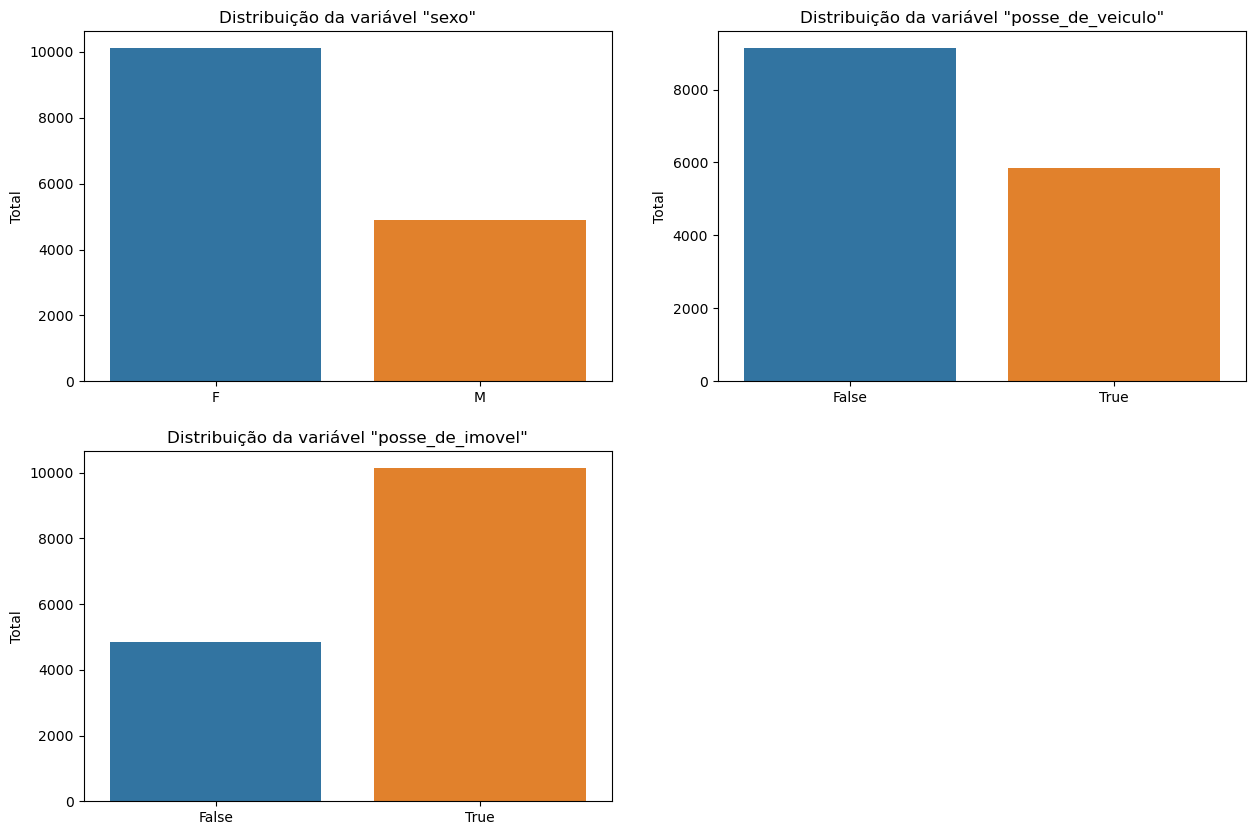

In [298]:
figura, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

sns.countplot(data = df, x = 'sexo', ax = ax1)
sns.countplot(data = df, x = 'posse_de_veiculo', ax = ax2)
sns.countplot(data = df, x = 'posse_de_imovel', ax = ax3)

ax1.set_title('Distribuição da variável "sexo"')
ax2.set_title('Distribuição da variável "posse_de_veiculo"')
ax3.set_title('Distribuição da variável "posse_de_imovel"')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.set_ylabel('Total')
ax2.set_ylabel('Total')
ax3.set_ylabel('Total')

ax4.remove()

### Variáveis numéricas

* **idade:** apresenta uma boa distribuição e não precisará ser tratada.
* **tempo_emprego:** possui outliers superiores que podem afetar o modelo.
* **qtd_filhos:** possui outliers que deverão ser tratados.
* **qt_pessoas_residencia:** possui outliers que deverãos ser tratados.

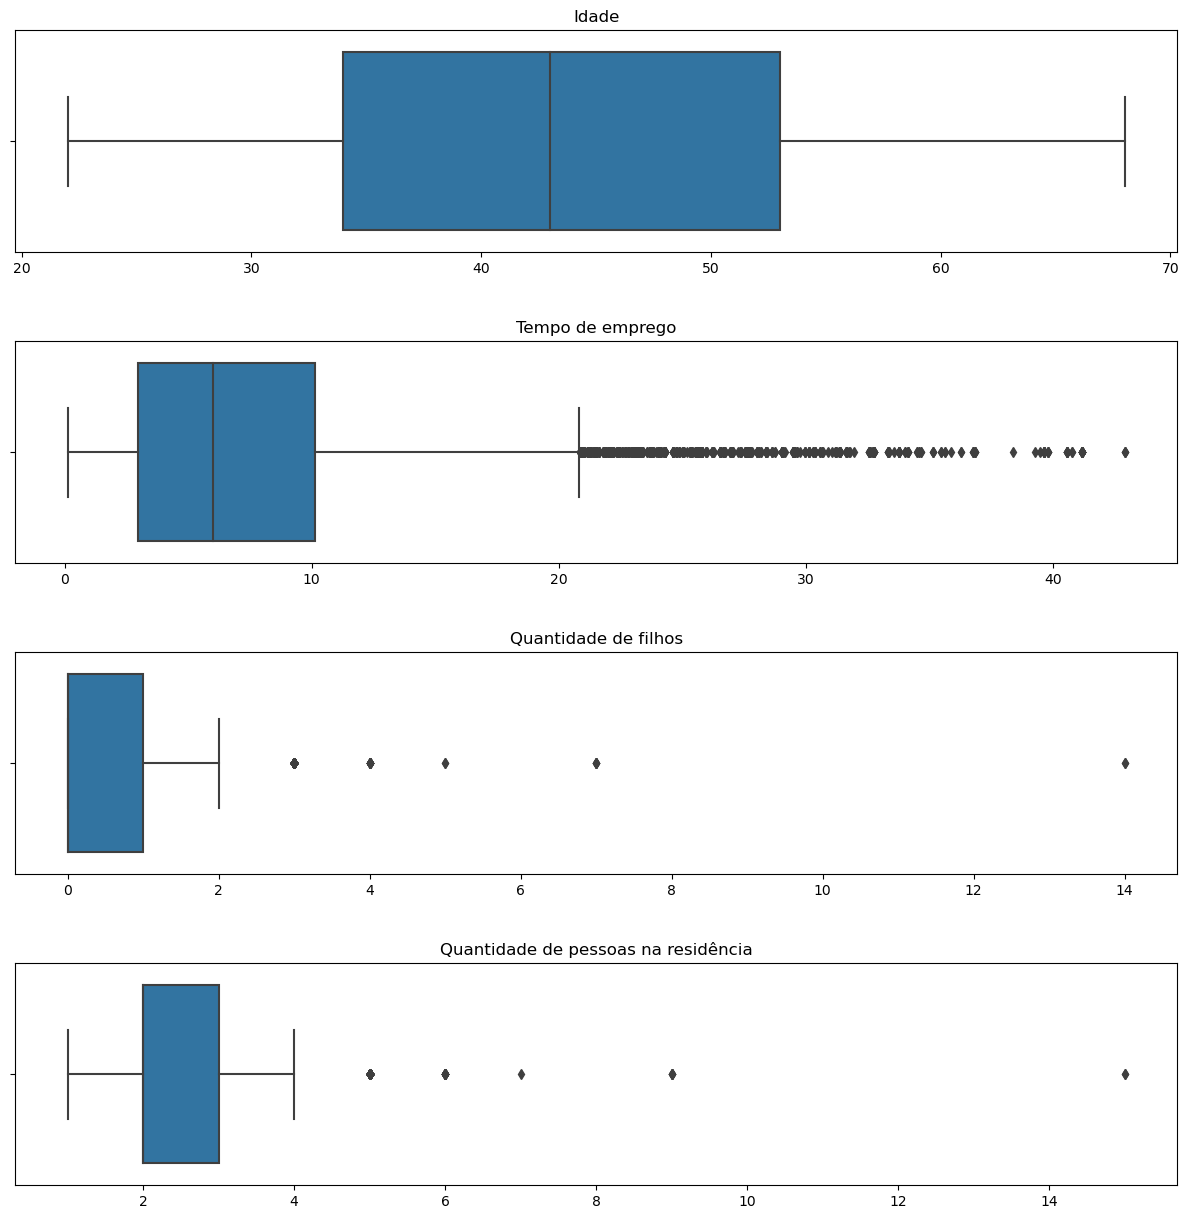

,count,mean,std,min,25%,50%,75%,max
idade,15000.0,43.882333,11.273155,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,12427.0,7.722635,6.711189,0.117808,2.973973,6.013699,10.120548,42.906849
qtd_filhos,15000.0,0.432333,0.746631,0.000000,0.000000,0.000000,1.000000,14.000000
qt_pessoas_residencia,15000.0,2.206400,0.909792,1.000000,2.000000,2.000000,3.000000,15.000000


In [299]:
figura, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15))

sns.boxplot(data = df, x = 'idade', ax = ax1)
sns.boxplot(data = df, x = 'tempo_emprego', ax = ax2)
sns.boxplot(data = df, x = 'qtd_filhos', ax = ax3)
sns.boxplot(data = df, x = 'qt_pessoas_residencia', ax = ax4)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_title('Idade')
ax2.set_title('Tempo de emprego')
ax3.set_title('Quantidade de filhos')
ax4.set_title('Quantidade de pessoas na residência')

figura.subplots_adjust(hspace=0.4, wspace=0.5)

plt.show()

df[ ['idade', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia'] ].describe().transpose()

### Variáveis categóricas

* **tipo_renda**: categoria "bolsista" com uma frequencia extremamente baixa.

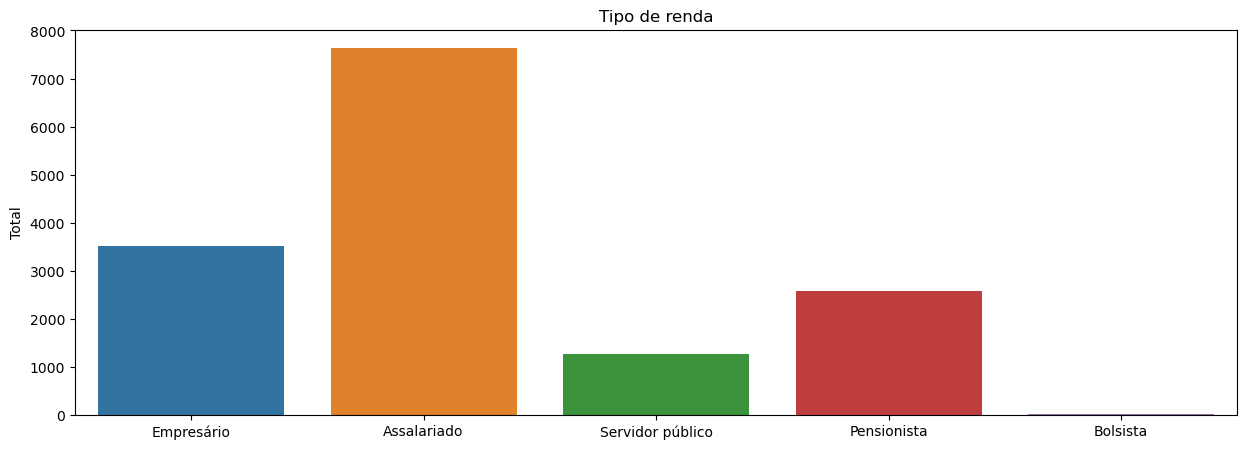

Assalariado         7633
Empresário          3508
Pensionista         2582
Servidor público    1268
Bolsista               9
Name: tipo_renda, dtype: int64

In [300]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'tipo_renda')
ax.set_title("Tipo de renda")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['tipo_renda'].value_counts()

- **educacao**: categoria "Pós graduação" com uma frequencia extremamente baixa.

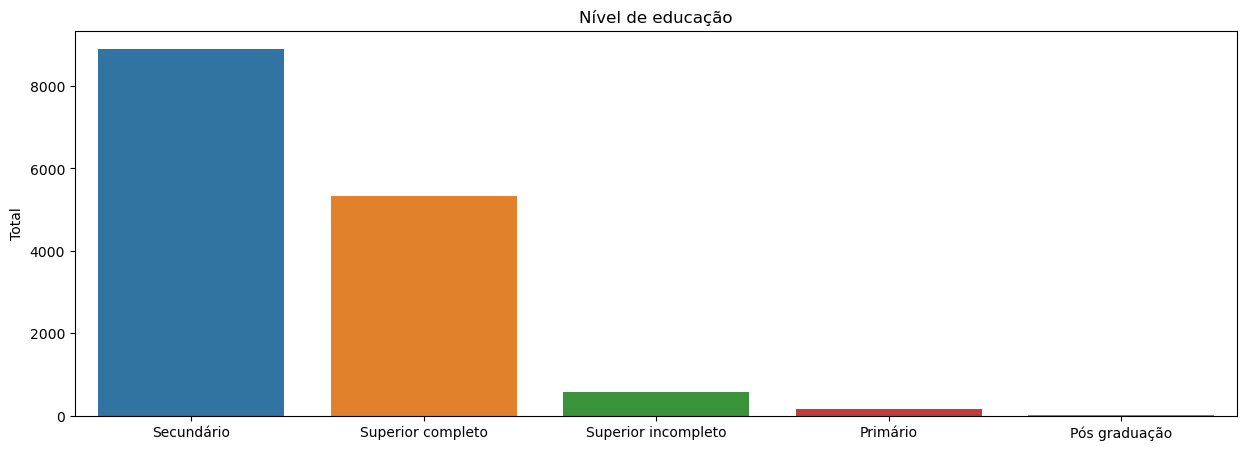

Secundário             8895
Superior completo      5335
Superior incompleto     579
Primário                165
Pós graduação            26
Name: educacao, dtype: int64

In [301]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'educacao')
ax.set_title("Nível de educação")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['educacao'].value_counts()

- **estado_civil**: dados aparentemente bem distribuídos, com a predominancia em "Casado"

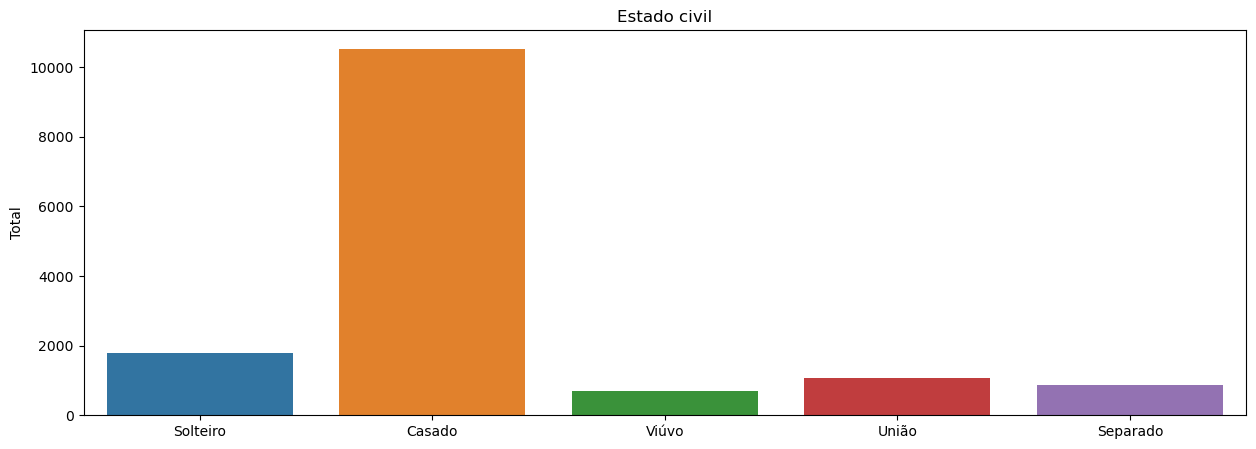

Casado      10534
Solteiro     1798
União        1078
Separado      879
Viúvo         711
Name: estado_civil, dtype: int64

In [302]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'estado_civil')
ax.set_title("Estado civil")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['estado_civil'].value_counts()

- **tipo_residencia**: categoria "Comunitário" com uma baixa frequência.

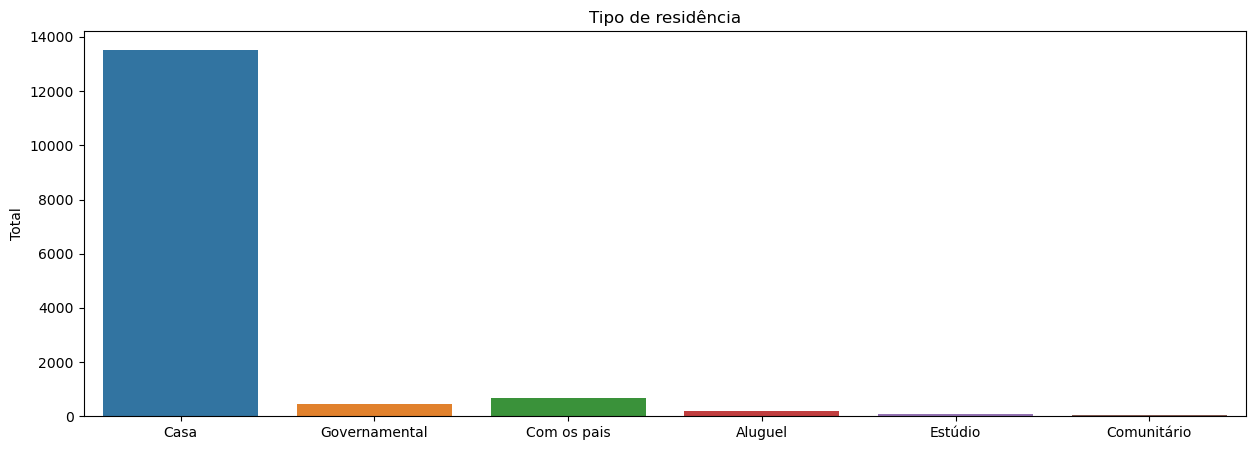

Casa             13532
Com os pais        675
Governamental      452
Aluguel            194
Estúdio             83
Comunitário         64
Name: tipo_residencia, dtype: int64

In [303]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'tipo_residencia')
ax.set_title("Tipo de residência")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['tipo_residencia'].value_counts()

### Entendimento dos dados - Bivariadas




### Renda X Variáveis Binárias

Analisando a relação entre as variáveis binárias e a variável resposta (renda), aparentemente a variável **sexo** apresenta uma diferença significante na renda entre suas duas categorias.

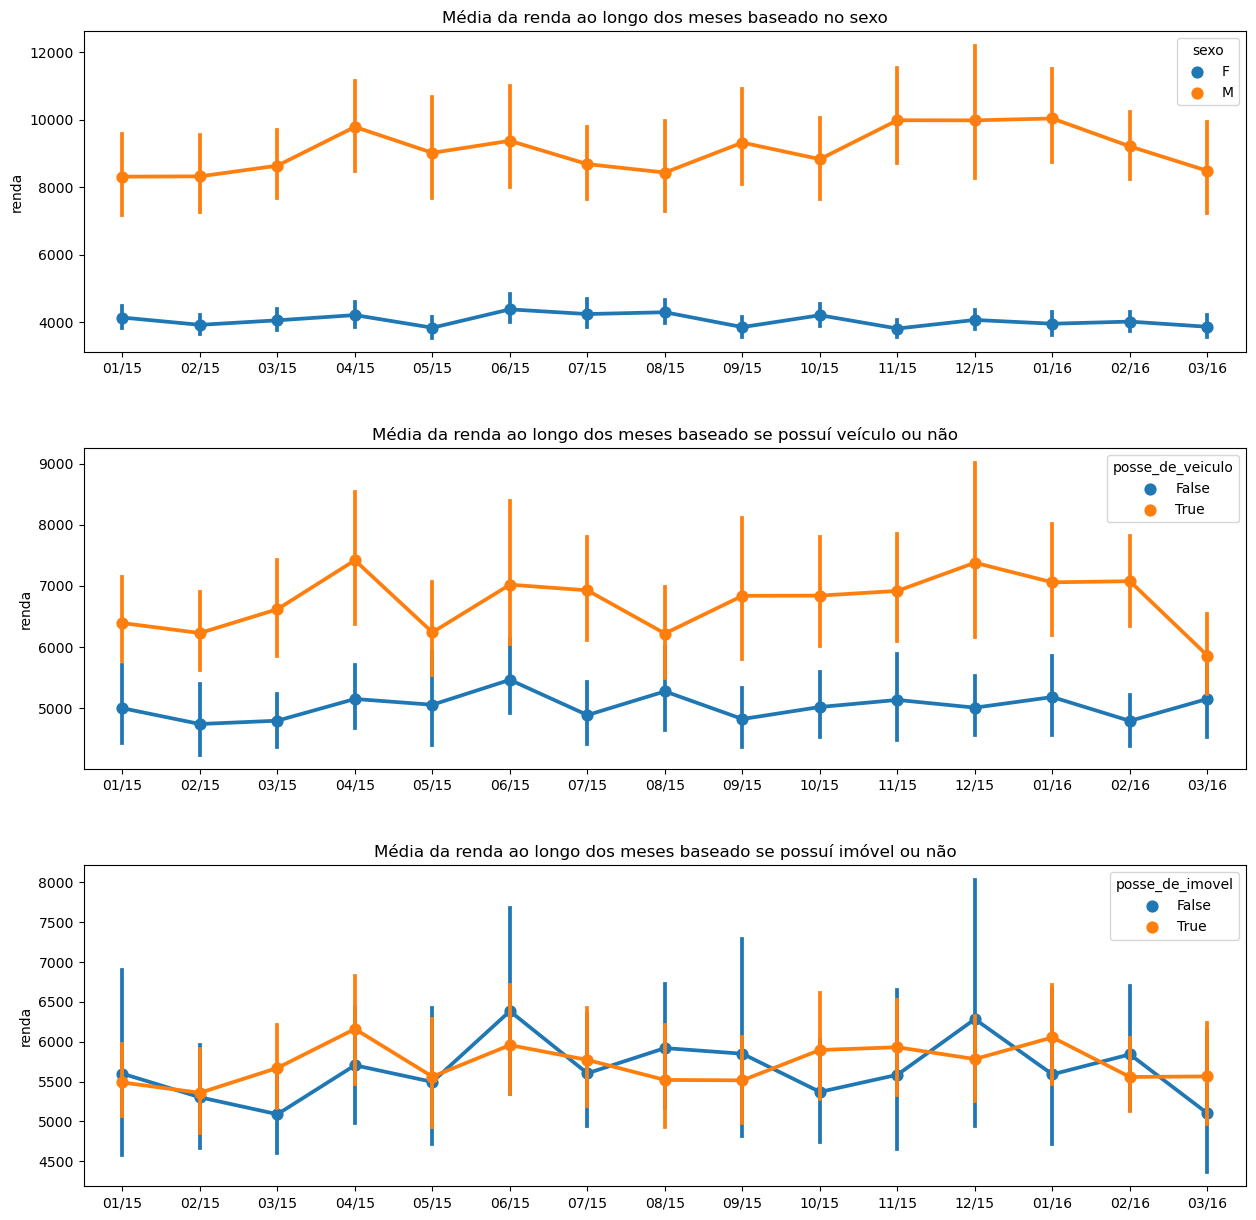

In [304]:
figura, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))

sns.pointplot(data = df, x = 'data_ref', y = 'renda', hue = 'sexo', ax = ax1)
sns.pointplot(data = df, x = 'data_ref', y = 'renda', hue = 'posse_de_veiculo', ax = ax2)
sns.pointplot(data = df, x = 'data_ref', y = 'renda', hue = 'posse_de_imovel', ax = ax3)

valores_x = pd.to_datetime(df['data_ref']).dt.strftime("%m/%y").unique()

ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")

ax1.set_title("Média da renda ao longo dos meses baseado no sexo")
ax2.set_title("Média da renda ao longo dos meses baseado se possuí veículo ou não")
ax3.set_title("Média da renda ao longo dos meses baseado se possuí imóvel ou não")

ax1.set_xticklabels(valores_x)
ax2.set_xticklabels(valores_x)
ax3.set_xticklabels(valores_x)

figura.subplots_adjust(hspace=0.3)

plt.show()

### Renda X Variáveis Numéricas

Para as variáveis numéricas, podemos analisar a correlação entre elas.

Dessas, a variável que aparenta ser mais útil para explicar a renda é o **tempo_emprego**, com uma correlação de 39%.

Nota-se também, que a correlação entre as variáveis **qt_pessoas_residencia** e **qtd_filhos** é bem alta (o que é esperado), no entanto, pode acarretar em problemas de *multicolinearidade*.

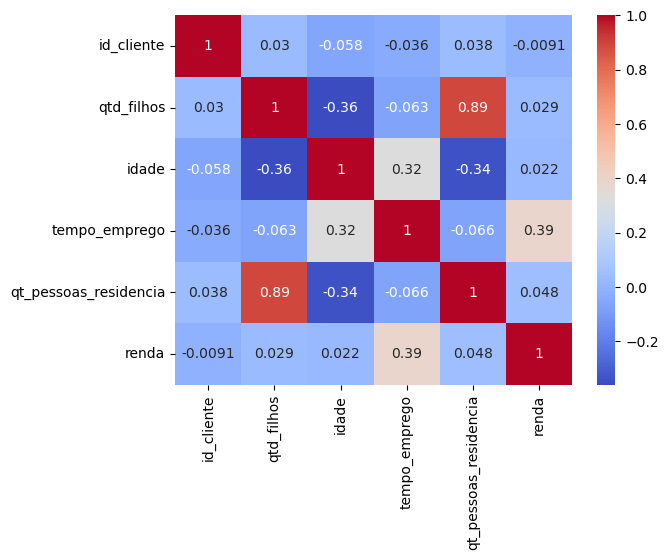

In [305]:
ax = sns.heatmap(df.select_dtypes('number').corr(),
                annot=True, 
                cmap='coolwarm')

plt.show()

### Renda X Variáveis Categóricas

Inicialmente, não nota-se diferença significante na renda baseado em nenhuma das variáveis. Mas ainda cabe analisar como ficará o p-value ao criar o modelo.

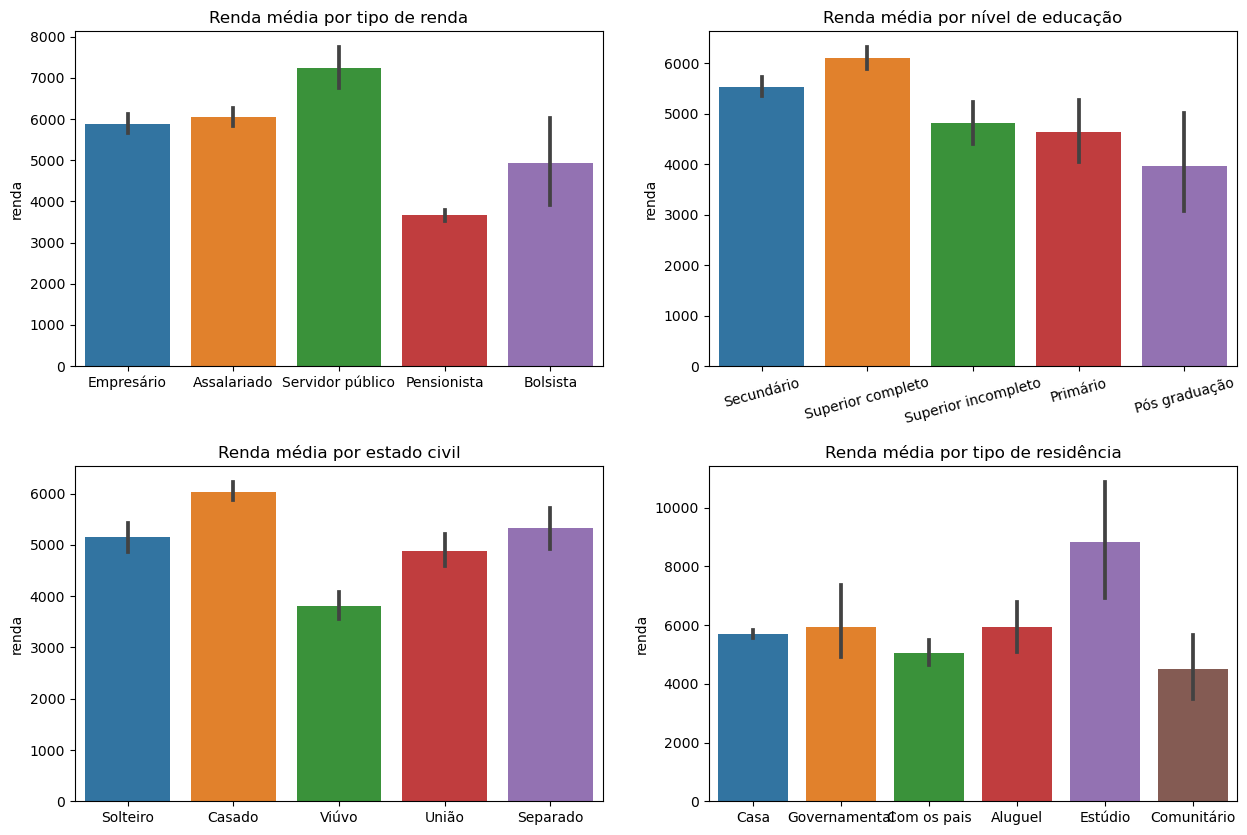

In [306]:
figura, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

sns.barplot(data = df, x = 'tipo_renda', y = 'renda', errorbar=('ci', 95), ax = ax1)
sns.barplot(data = df, x = 'educacao', y = 'renda', errorbar=('ci', 95), ax = ax2)
sns.barplot(data = df, x = 'estado_civil', y = 'renda', errorbar=('ci', 95), ax = ax3)
sns.barplot(data = df, x = 'tipo_residencia', y = 'renda', errorbar=('ci', 95), ax = ax4)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15)

ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")

ax1.set_title("Renda média por tipo de renda")
ax2.set_title("Renda média por nível de educação")
ax3.set_title("Renda média por estado civil")
ax4.set_title("Renda média por tipo de residência")

figura.subplots_adjust(hspace=0.3)

plt.show()

## Etapa 3 Crisp-DM: Preparação dos dados

##### Seleção:

* Remoção da variável **data_ref** e **id_cliente** que não serão utilizadas nos modelos.

In [307]:
df.drop(columns=['id_cliente', 'data_ref'], inplace=True)

df.head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15


## Etapa 4 Crisp-DM: Modelagem

##### Rodando o modelo


In [308]:
reg = smf.ols('renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia ''', 
              data = df).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     211.8
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:14:28   Log-Likelihood:            -1.2880e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12406   BIC:                         2.578e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -5211.5527   2501.465     -2.083      0.037   -1.01e+04    -308.292
sexo[T.M]                         6012.5858    155.726     38.610      0.000    5707.340    6317.832
posse_de_veiculo[T.True]            62.7495    150.465      0.417      0.677    -232.186     357.685
posse_de_imovel[T.True]            372.0577    148.822      2.500      0.012      80.343     663.773
educacao[T.Pós graduação]         1357.6468   1691.327      0.803      0.422   -1957.617    4672.911
educacao[T.Secundário]             679.9616    766.295      0.887      0.375    -822.095    2182.018
educacao[T.Superior completo]     1351.6946    768.622      1.759      0.079    -154.925    2858.314
educacao[T.Superior incompleto]    348.3263    827.553      0.421      0.674   -1273.807    1970.459
estado_civil[T.Separado]          1101.0993   1184.078      0.930      0.352   -1219.877    3422.076
estado_civil[T.Solteiro]           768.2827   1159.266      0.663      0.508   -1504.058    3040.623
estado_civil[T.União]             -427.0078    267.815     -1.594      0.111    -951.967      97.951
estado_civil[T.Viúvo]              916.8890   1230.207      0.745      0.456   -1494.507    3328.285
tipo_residencia[T.Casa]           -298.8712    576.380     -0.519      0.604   -1428.665     830.922
tipo_residencia[T.Com os pais]    -455.1854    642.362     -0.709      0.479   -1714.314     803.943
tipo_residencia[T.Comunitário]    -584.2604   1121.376     -0.521      0.602   -2782.331    1613.810
tipo_residencia[T.Estúdio]         186.3163   1056.458      0.176      0.860   -1884.506    2257.139
tipo_residencia[T.Governamental]    86.9789    702.385      0.124      0.901   -1289.805    1463.762
qtd_filhos                       -1069.9553   1149.000     -0.931      0.352   -3322.174    1182.263
idade                               40.7862      8.520      4.787      0.000      24.085      57.487
tempo_emprego                      549.6470     10.929     50.292      0.000     528.224     571.070
qt_pessoas_residencia             1188.2018   1146.888      1.036      0.300   -1059.877    3436.281
==============================================================================
Omnibus:                    17535.414   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9771327.389
Skew:                           8.097   Prob(JB):                         0.00
Kurtosis:                     139.414   Cond. No.                     2.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+03. This might indicate that there are
stron

## Etapa 5 Crisp-DM: Avaliação dos resultados

In [309]:
print(f'O modelo criado possui r-quadrado de {reg.rsquared*100:2f}')
print(f'O modelo criado possui AIC de {reg.aic*100:2f}')

O modelo criado possui r-quadrado de 25.449472
O modelo criado possui AIC de 25764727.340895


Notou-se pelo modelo criado que as variáveis que possuem mais importancia para a predefinição de renda são sexo, idade, tempo_emprego, posse_de_imovel, tipo_renda, posse_de_veiculo e educacao

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

* Neste caso, será gerado um scritp a parte na pasta do projeto que será uma página Streamlit.